## Preprocessing

In [1]:
import os
import pandas as pd
import numpy as np
import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import plot_importance
import lightgbm as lgb
from lightgbm import LGBMClassifier
from sklearn.preprocessing import LabelEncoder
import shap
import matplotlib.pyplot as plt
import tqdm
from timeit import default_timer as timer

from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [2]:
os.chdir('c:/users/fre_f/pythonprojects/bacteriological/')

In [3]:
df = pd.read_csv('./data/final/03_family_desl_ra.csv')

In [4]:
df.head()

,Index,DESL,Corynebacteriaceae,Staphylococcaceae,Propionibacteriaceae,Neisseriaceae,Moraxellaceae,Lachnospiraceae,Family XI,Lactobacillaceae,...,Monopoex (Y_N),Artifical tears,Light treatment,TBUT OD,TBUT OS,OSS OD,OSS OS,ST OD,ST OS,Demodicosis
0,P1,3,0.092816,0.001058,0.042075,0.0,0.006020,0.092352,0.0,0.000000,...,1,0,0,3,3,0,0,23,23,0
1,P2,3,0.698862,0.001191,0.004366,0.0,0.000000,0.012305,0.0,0.000000,...,1,1,0,2,4,1,3,14,18,0
2,P3,2,0.034017,0.259365,0.003640,0.0,0.000000,0.088352,0.0,0.013501,...,0,1,1,8,8,3,3,11,8,0
3,P4,3,0.029042,0.177362,0.015877,0.0,0.000000,0.127216,0.0,0.003109,...,0,1,0,3,2,2,2,12,11,0
4,P5,1,0.308125,0.164086,0.050351,0.0,0.004896,0.018195,0.0,0.000000,...,1,1,1,11,11,0,0,22,32,0


In [5]:
df.iloc[:,2:155]

,Corynebacteriaceae,Staphylococcaceae,Propionibacteriaceae,Neisseriaceae,Moraxellaceae,Lachnospiraceae,Family XI,Lactobacillaceae,Carnobacteriaceae,Micrococcaceae,...,Cellvibrionaceae,*Lariskella,Boechera gunnisoniana,Myrmecia israelensis,Acidimicrobiaceae,Nitrospiraceae,Methylophilaceae,Parachlamydiaceae,Salinisphaeraceae,Sporichthyaceae
0,0.092816,0.001058,0.042075,0.000000,0.006020,0.092352,0.000000,0.000000,0.053850,0.000000,...,0,0,0,0,0,0,0.0,0,0.0,0
1,0.698862,0.001191,0.004366,0.000000,0.000000,0.012305,0.000000,0.000000,0.001985,0.000000,...,0,0,0,0,0,0,0.0,0,0.0,0
2,0.034017,0.259365,0.003640,0.000000,0.000000,0.088352,0.000000,0.013501,0.004964,0.032363,...,0,0,0,0,0,0,0.0,0,0.0,0
3,0.029042,0.177362,0.015877,0.000000,0.000000,0.127216,0.000000,0.003109,0.053056,0.006946,...,0,0,0,0,0,0,0.0,0,0.0,0
4,0.308125,0.164086,0.050351,0.000000,0.004896,0.018195,0.000000,0.000000,0.118698,0.000265,...,0,0,0,0,0,0,0.0,0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56,0.358462,0.185519,0.108214,0.016877,0.003177,0.090807,0.011847,0.000000,0.000000,0.000000,...,0,0,0,0,0,0,0.0,0,0.0,0
57,0.114117,0.355253,0.048227,0.000000,0.005094,0.040487,0.000000,0.000000,0.046110,0.000000,...,0,0,0,0,0,0,0.0,0,0.0,0
58,0.296309,0.601019,0.004895,0.000000,0.000000,0.004631,0.001257,0.000000,0.000000,0.000000,...,0,0,0,0,0,0,0.0,0,0.0,0
59,0.839706,0.046375,0.005028,0.000000,0.006285,0.017465,0.000000,0.000000,0.000000,0.000728,...,0,0,0,0,0,0,0.0,0,0.0,0


In [6]:
df.iloc[:,1]

0     3
1     3
2     2
3     3
4     1
     ..
56    3
57    2
58    2
59    2
60    3
Name: DESL, Length: 61, dtype: int64

In [7]:
X = df.iloc[:,2:155]
y = df.iloc[:,1]

## Train, predict and explain

### XGBoost

In [8]:
le = LabelEncoder()
y_xgb = le.fit_transform(y)

clfxgb = XGBClassifier().fit(X, y_xgb)
y_predxgb = clfxgb.predict(X)
y_predxgb = le.inverse_transform(y_predxgb)

In [9]:
print('Accuracy:',accuracy_score(y, y_predxgb))
print('Balanced accuracy: ',balanced_accuracy_score(y, y_predxgb))
print('F1 score:',f1_score(y, y_predxgb,average='weighted'))
print('MCC:', matthews_corrcoef(y, y_predxgb))
print(confusion_matrix(y, y_predxgb))

Accuracy: 1.0
Balanced accuracy:  1.0
F1 score: 1.0
MCC: 1.0
[[ 8  0  0  0]
 [ 0 18  0  0]
 [ 0  0 31  0]
 [ 0  0  0  4]]


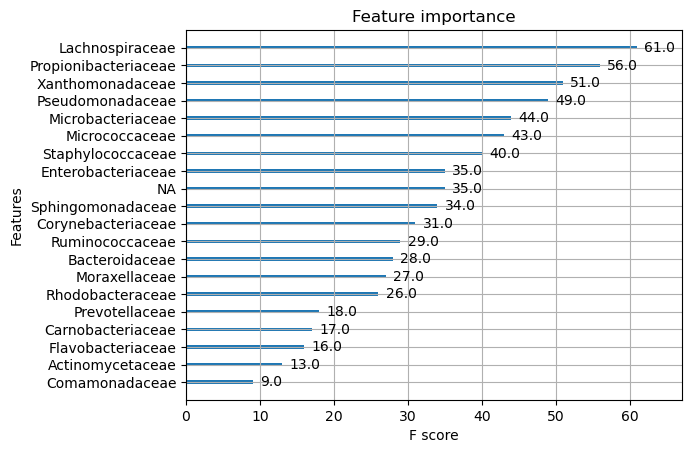

In [10]:
fig, ax = plt.subplots()
plot_importance(clfxgb, max_num_features = 20, ax=ax)
plt.title('Feature importance')

plt.show()

[09:25:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


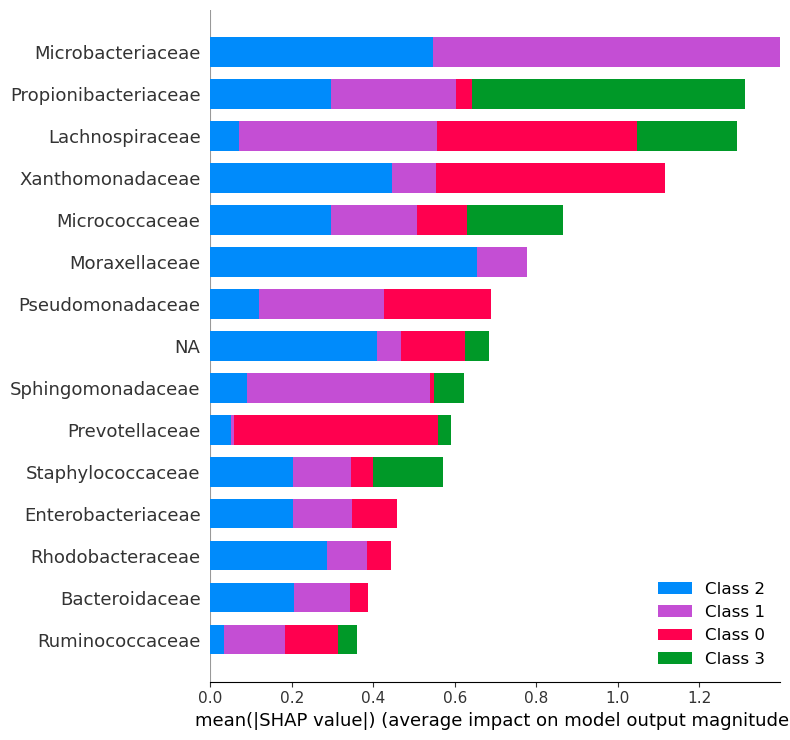

In [11]:
# Create a SHAP explainer for the XGBoost model
explainerxgb = shap.Explainer(clfxgb, X)

shap_valuesxgb = explainerxgb.shap_values(X.iloc[:,:])

shap.summary_plot(shap_valuesxgb, X, plot_type='bar', max_display=15)

In [12]:
# Make a customized SHAP plot with global values for each feaature

my_featuresxgb = clfxgb.get_booster().feature_names

shap_listxgb0 = []
shap_listxgb1 = []
shap_listxgb2 = []
shap_listxgb3 = []

for i in range(25):
    shap_listxgb0.append(abs(shap_valuesxgb[0][:,i,]).mean())
    shap_listxgb1.append(abs(shap_valuesxgb[1][:,i,]).mean())
    shap_listxgb2.append(abs(shap_valuesxgb[2][:,i,]).mean())
    shap_listxgb3.append(abs(shap_valuesxgb[3][:,i,]).mean())
    
shap_dictxgb = {}
# Add up shap values from all four classes (DESL 1-4)
for i in range(len(shap_listxgb0)):
    shap_dictxgb[my_featuresxgb[i]] = shap_listxgb0[i]
    shap_dictxgb[my_featuresxgb[i]] += shap_listxgb1[i]
    shap_dictxgb[my_featuresxgb[i]] += shap_listxgb2[i]
    shap_dictxgb[my_featuresxgb[i]] += shap_listxgb3[i]
    
# Sort in decreasing order
shap_dictxgb = {k:v for k, v in sorted(shap_dictxgb.items(), key=lambda item: item[1], reverse=True)}

most_important_featuresxgb = []
most_important_valuesxgb = []

for k, v in shap_dictxgb.items():
    most_important_featuresxgb.append(k)
    most_important_valuesxgb.append(v)
    
# Choose top X features
most_important_featuresxgb = most_important_featuresxgb[:20]
most_important_valuesxgb = most_important_valuesxgb[:20]

most_important_featuresxgb.reverse()
most_important_valuesxgb.reverse()

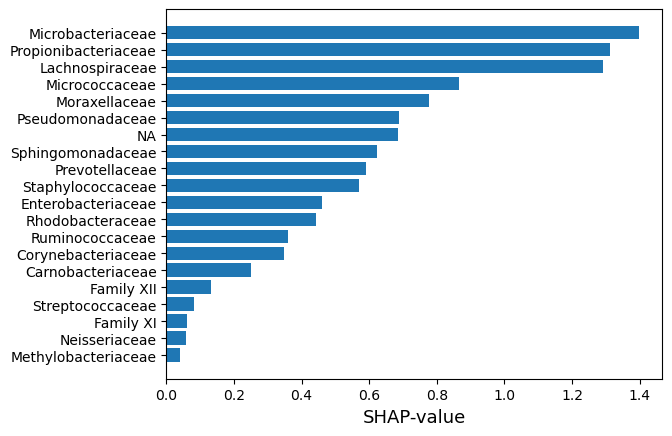

In [13]:
plt.barh(most_important_featuresxgb, most_important_valuesxgb)
ax = plt.gca()
plt.xlabel('SHAP-value', size=13)
plt.show()

### LightGBM

In [14]:
clflgbm = LGBMClassifier(random_state=42)
clflgbm.fit(X, y)
y_pred = clflgbm.predict(X)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000083 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 296
[LightGBM] [Info] Number of data points in the train set: 61, number of used features: 21
[LightGBM] [Info] Start training from score -2.031432
[LightGBM] [Info] Start training from score -1.220502
[LightGBM] [Info] Start training from score -0.676887
[LightGBM] [Info] Start training from score -2.724580
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

In [15]:
print('Accuracy:',accuracy_score(y, y_pred))
print('Balanced accuracy: ',balanced_accuracy_score(y, y_pred))
print('F1 score:',f1_score(y, y_pred,average='weighted'))
print('MCC:', matthews_corrcoef(y, y_pred))
print(confusion_matrix(y, y_pred))

Accuracy: 0.8852459016393442
Balanced accuracy:  0.8565188172043011
F1 score: 0.8813809141677994
MCC: 0.8176172135765442
[[ 5  1  2  0]
 [ 0 15  3  0]
 [ 0  1 30  0]
 [ 0  0  0  4]]


<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

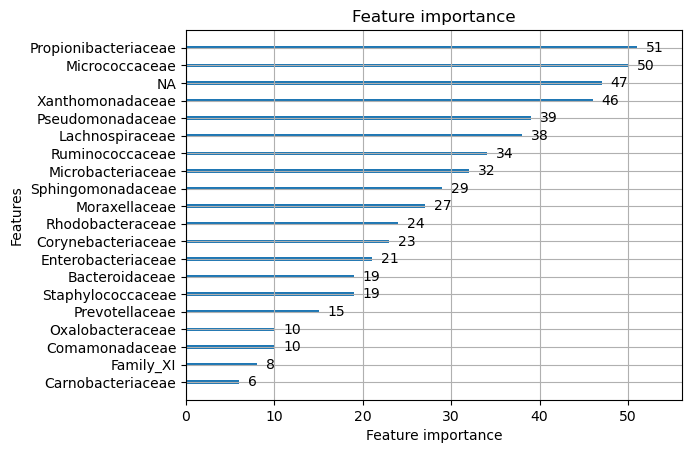

In [16]:
lgb.plot_importance(clflgbm, max_num_features=20, ignore_zero=False)

In [17]:
# Create a SHAP explainer for the LightGBM model

explainerlgbm = shap.Explainer(clflgbm, X)

In [18]:
# Compute SHAP values for the dataset

#shap_valueslgbm = explainerlgbm(X)
shap_valueslgbm = explainerlgbm.shap_values(X.iloc[:,:])

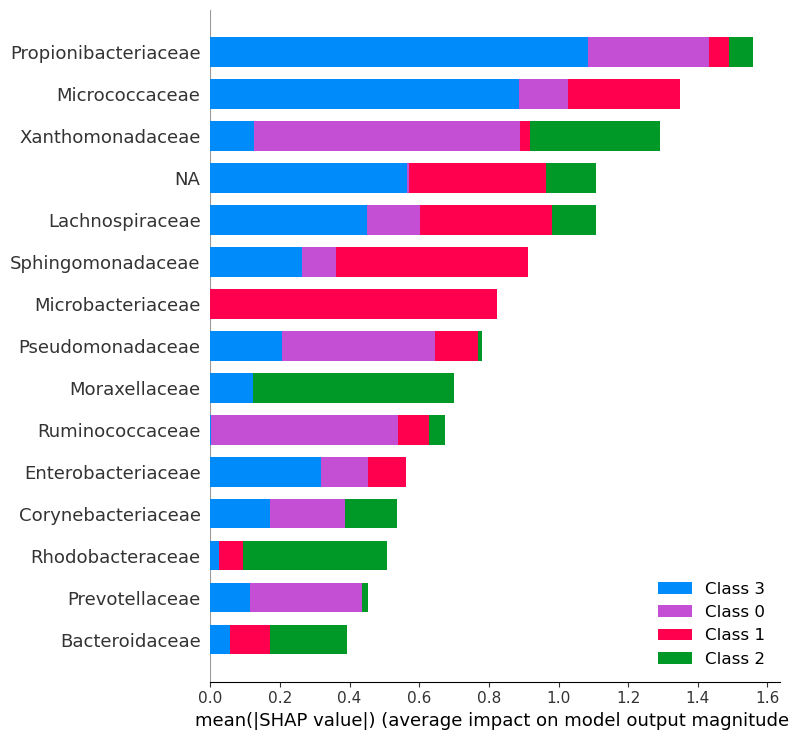

In [19]:
shap.summary_plot(shap_valueslgbm, X, plot_type='bar', max_display=15)

In [20]:
# Make a customized SHAP plot with global values for each feaature

my_features = clflgbm.feature_name_

shap_list0 = []
shap_list1 = []
shap_list2 = []
shap_list3 = []

for i in range(25):
    shap_list0.append(abs(shap_valueslgbm[0][:,i,]).mean())
    shap_list1.append(abs(shap_valueslgbm[1][:,i,]).mean())
    shap_list2.append(abs(shap_valueslgbm[2][:,i,]).mean())
    shap_list3.append(abs(shap_valueslgbm[3][:,i,]).mean())
    
shap_dict = {}
# Add up shap values from all four classes (DESL 1-4)
for i in range(len(shap_list0)):
    shap_dict[my_features[i]] = shap_list0[i]
    shap_dict[my_features[i]] += shap_list1[i]
    shap_dict[my_features[i]] += shap_list2[i]
    shap_dict[my_features[i]] += shap_list3[i]
    
# Sort in decreasing order
shap_dict = {k:v for k, v in sorted(shap_dict.items(), key=lambda item: item[1], reverse=True)}

most_important_features = []
most_important_values = []

for k, v in shap_dict.items():
    most_important_features.append(k)
    most_important_values.append(v)
    
# Choose top X features
most_important_features = most_important_features[:20]
most_important_values = most_important_values[:20]

most_important_features.reverse()
most_important_values.reverse()

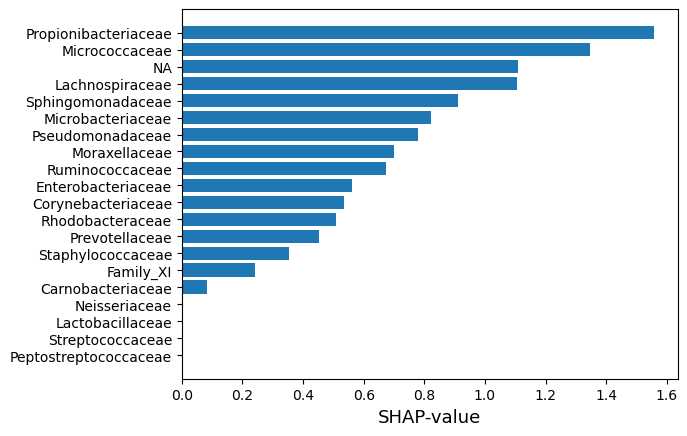

In [21]:
plt.barh(most_important_features, most_important_values)
ax = plt.gca()
plt.xlabel('SHAP-value', size=13)
plt.show()

### Multilayer perceptron 

In [22]:
from sklearn.neural_network import MLPClassifier
clfmlp = MLPClassifier(solver="adam", activation="relu", learning_rate="constant", random_state=42, max_iter=3000, verbose=False)
clfmlp.out_activation_="softmax"
clfmlp.fit(X, y)
y_predmlp = clfmlp.predict(X)

In [23]:
print('Accuracy:',accuracy_score(y, y_predmlp))
print('Balanced accuracy: ',balanced_accuracy_score(y, y_predmlp))
print('F1 score:',f1_score(y, y_predmlp,average='weighted'))
print('MCC:', matthews_corrcoef(y, y_predmlp))
print(confusion_matrix(y, y_predmlp))

Accuracy: 0.9836065573770492
Balanced accuracy:  0.9861111111111112
F1 score: 0.9835024720270621
MCC: 0.974398280806329
[[ 8  0  0  0]
 [ 0 17  1  0]
 [ 0  0 31  0]
 [ 0  0  0  4]]


In [24]:
from sklearn.inspection import permutation_importance
result = permutation_importance(clfmlp,X, y,n_repeats=20, random_state = 42)

In [25]:
N=15

MLPfeatures = pd.DataFrame(clfmlp.feature_names_in_,columns=['Features'])
MLPfeatures['Importance_values'] = result.importances_mean.tolist()
#Sort by importance
MLPfeatures = MLPfeatures.sort_values(by = 'Importance_values',ascending=True)[-N:]
#Remove features with importance =0
MLPfeatures=MLPfeatures[MLPfeatures['Importance_values']!=0]

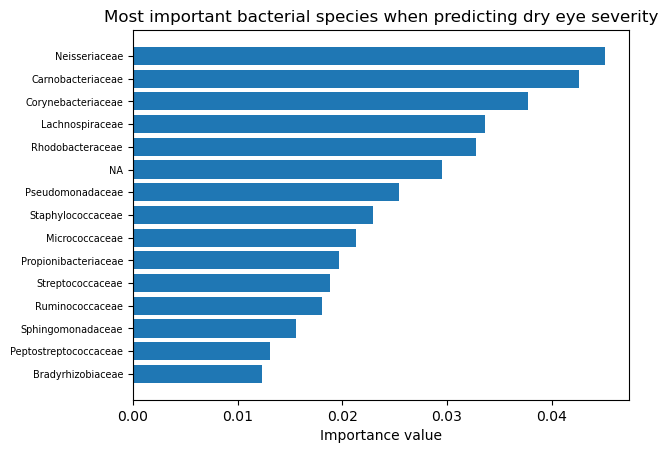

In [26]:
plt.title('Most important bacterial species when predicting dry eye severity')
plt.xlabel('Importance value')
plt.yticks(size=7)
plt.barh(MLPfeatures['Features'], MLPfeatures['Importance_values'], height=0.8)
plt.show()